In [ ]:
# Gerekli kütüphaneleri import etme
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [ ]:
# Google Drive'ı bağlama
from google.colab import drive
drive.mount('/content/drive')

# Veri seti yolunu tanımlama
base_dir = '/content/drive/MyDrive/Proje17/chest_xray'
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

print("Google Drive bağlandı ve veri seti yolları tanımlandı.")


Mounted at /content/drive
Google Drive bağlandı ve veri seti yolları tanımlandı.


In [ ]:
# Eğitim ve validasyon veri artırma
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

# Eğitim ve validasyon verilerini yükleme
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

print("Eğitim ve validasyon verileri başarıyla yüklendi.")


Found 2415 images belonging to 2 classes.
Found 268 images belonging to 2 classes.
Eğitim ve validasyon verileri başarıyla yüklendi.


In [ ]:
# Modeli oluşturma
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    ),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

None


In [ ]:
# Callbacks tanımlama
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    'resnet50_best_model.keras', save_best_only=True, monitor='val_loss', mode='min'
)

print("Callbacks başarıyla tanımlandı.")


Callbacks başarıyla tanımlandı.


In [ ]:
# Model eğitimi
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stopping, model_checkpoint]
)

print("Model eğitimi tamamlandı.")


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


76/76 ━━━━━━━━━━━━━━━━━━━━ 1176s 14s/step - accuracy: 0.5320 - loss: 0.9232 - val_accuracy: 0.7313 - val_loss: 0.5605
Epoch 2/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 76s 896ms/step - accuracy: 0.6675 - loss: 0.6664 - val_accuracy: 0.8470 - val_loss: 0.4401
Epoch 3/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 80s 891ms/step - accuracy: 0.7347 - loss: 0.5694 - val_accuracy: 0.8806 - val_loss: 0.3650
Epoch 4/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 81s 890ms/step - accuracy: 0.7708 - loss: 0.4915 - val_accuracy: 0.8582 - val_loss: 0.3488
Epoch 5/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 83s 899ms/step - accuracy: 0.8024 - loss: 0.4552 - val_accuracy: 0.8918 - val_loss: 0.3078
Epoch 6/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 74s 879ms/step - accuracy: 0.8135 - loss: 0.4401 - val_accuracy: 0.8881 - val_loss: 0.2887
Epoch 7/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 79s 953ms/step - accuracy: 0.8174 - loss: 0.3936 - val_accuracy: 0.8918 - val_loss: 0.2777
Epoch 8/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 74s 888ms/step - accuracy: 0.8214 - loss: 0.3897 - val_accuracy: 0.888

In [ ]:
# Test verisi
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

print("Test verileri başarıyla yüklendi.")


Found 624 images belonging to 2 classes.
Test verileri başarıyla yüklendi.


In [ ]:
# Test seti değerlendirme
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 179s 9s/step - accuracy: 0.8671 - loss: 0.3574
Test Loss: 0.3528, Test Accuracy: 0.8622


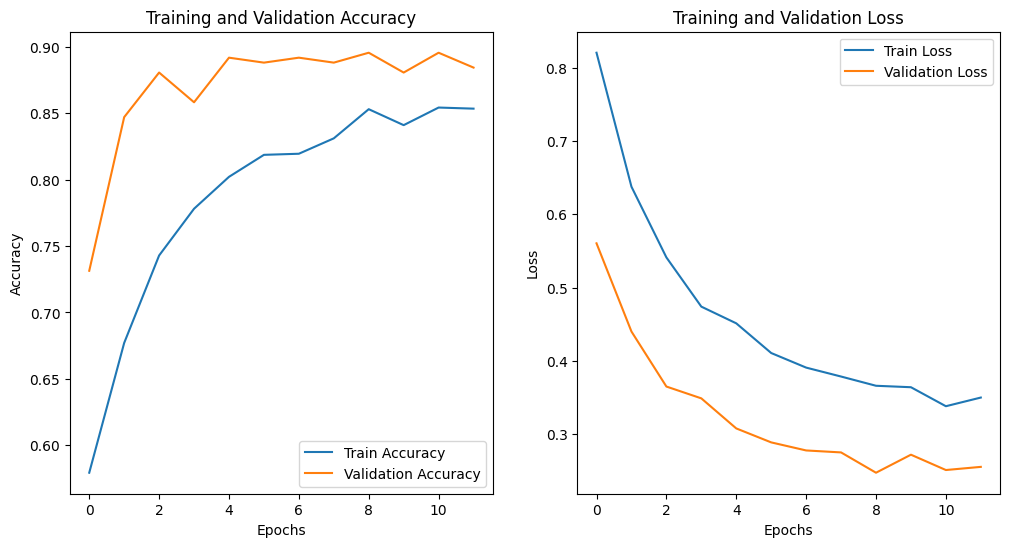

Eğitim ve doğrulama eğrileri başarıyla çizildi!


In [ ]:
# Eğitim/Doğrulama eğrilerini çizme
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

print("Eğitim ve doğrulama eğrileri başarıyla çizildi!")


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 479ms/step


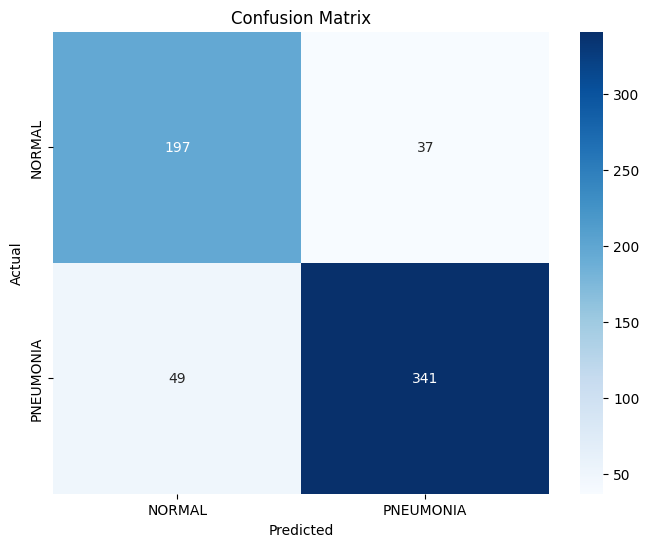

Model değerlendirmesi tamamlandı.


In [ ]:
# Confusion Matrix
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred).astype(int).flatten()
y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Model değerlendirmesi tamamlandı.")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Modeli .keras formatında kaydet
model_save_path = '/content/resnet50-model.keras'
model.save(model_save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
files.download(model_save_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Tahminler ve gerçek etiketler
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred).astype(int).flatten()  # Tahminleri 0 ve 1 olarak yuvarlama
y_true = test_generator.classes  # Gerçek etiketler

# Precision, Recall ve F1 Score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 317ms/step
Precision: 0.9021
Recall: 0.8744
F1 Score: 0.8880


In [ ]:
from sklearn.metrics import classification_report

# Tahminler ve gerçek etiketler
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred).astype(int).flatten()  # Tahminleri 0 ve 1 olarak yuvarlama
y_true = test_generator.classes  # Gerçek etiketler

# Detaylı sınıflandırma raporu
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print(report)


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 383ms/step
              precision    recall  f1-score   support

      NORMAL       0.80      0.84      0.82       234
   PNEUMONIA       0.90      0.87      0.89       390

    accuracy                           0.86       624
   macro avg       0.85      0.86      0.85       624
weighted avg       0.86      0.86      0.86       624

